Deep Q learning agent

In [37]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt

In [38]:
# Define the Q-network
class QNetwork(nn.Module):
    def setup(self):
        self.dense1 = nn.Dense(64)
        self.dense2 = nn.Dense(64)
        self.dense3 = nn.Dense(2)

    def __call__(self, x):
        x = self.dense1(x)
        x = jax.nn.relu(x)
        x = self.dense2(x)
        x = jax.nn.relu(x)
        x = self.dense3(x)
        return x

# Define the agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, batch_size, buffer_size=100000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)

        self.model = QNetwork()
        self.params = self.model.init(jax.random.PRNGKey(42), jnp.zeros((state_dim,)))
        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(self.params)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, apply_epsilon=True):
        """
        explore_noise: True for training, False for testing
        """
        if apply_epsilon and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        q_values = self.model.apply(self.params, state)
        return int(jnp.argmax(q_values))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = list(zip(*batch))
        states = jnp.stack(states)
        actions = jnp.array(actions)
        rewards = jnp.array(rewards)
        next_states = jnp.stack(next_states)
        dones = jnp.array(dones, dtype=jnp.float32)

        def loss_fn(params):
            q_values = self.model.apply(params, states)
            q_next = self.model.apply(params, next_states)
            q_target = rewards + (1.0 - dones) * self.gamma * jnp.max(q_next, axis=1)
            q_pred = jnp.take_along_axis(q_values, actions[:, None], axis=1).squeeze()
            return jnp.mean((q_pred - q_target) ** 2)

        loss, grads = jax.value_and_grad(loss_fn)(self.params)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Episode 1, Total Reward: 15.0
Episode 2, Total Reward: 26.0
Episode 3, Total Reward: 11.0
Episode 4, Total Reward: 19.0
Episode 5, Total Reward: 13.0
Episode 6, Total Reward: 42.0
Episode 7, Total Reward: 13.0
Episode 8, Total Reward: 30.0
Episode 9, Total Reward: 24.0
Episode 10, Total Reward: 11.0
Episode 11, Total Reward: 13.0
Episode 12, Total Reward: 18.0
Episode 13, Total Reward: 10.0
Episode 14, Total Reward: 37.0
Episode 15, Total Reward: 26.0
Episode 16, Total Reward: 26.0
Episode 17, Total Reward: 19.0
Episode 18, Total Reward: 20.0
Episode 19, Total Reward: 16.0
Episode 20, Total Reward: 16.0
Episode 21, Total Reward: 47.0
Episode 22, Total Reward: 13.0
Episode 23, Total Reward: 44.0
Episode 24, Total Reward: 35.0
Episode 25, Total Reward: 27.0
Episode 26, Total Reward: 40.0
Episode 27, Total Reward: 52.0
Episode 28, Total Reward: 20.0
Episode 29, Total Reward: 17.0
Episode 30, Total Reward: 16.0
Episode 31, Total Reward: 46.0
Episode 32, Total Reward: 51.0
Episode 33, Total

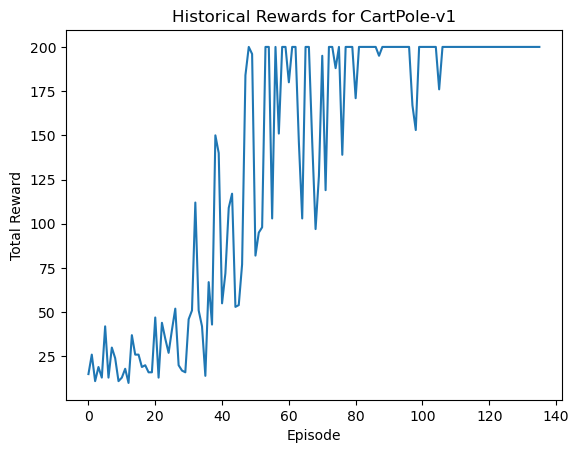

In [39]:
# Train the agent
env = gym.make("CartPole-v1", render_mode="rgb_array").env
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64)

n_episodes = 500
reward_history = []
max_episode_steps=200 # env.spec.max_episode_steps
reward_threshold=175 # env.spec.reward_threshold
solved_window = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False
    step_in_episode = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward
        step_in_episode += 1

        # check if the max_episode_steps are met. if so, terminate this episode
        if step_in_episode >= max_episode_steps:
            print(f"Agent reached max_episode_steps in episode {episode}.")
            break

    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"CartPole-v1 solved in {episode} episodes!")
            break

# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for CartPole-v1")
plt.show()


In [40]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

# Test the trained agent
n_test_episodes = 10

print("\nTesting the trained agent...")
for episode in range(n_test_episodes):
    state, _ = env.reset()
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False
    pre_screen = env.render()
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)
        screen = env.render()
        state = next_state
        total_reward += reward
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

    ipythondisplay.clear_output(wait=True)
    
    print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")

env.close()


ModuleNotFoundError: No module named 'pyvirtualdisplay'